# TensorFlow Machine Learning with Financial Data on Google Cloud Platform

This solution presents an accessible, non-trivial example of machine learning with financial time series on Google Cloud Platform (GCP).

Time series are an essential part of financial analysis. Today, you have more data at your disposal than ever, more sources of data, and more frequent delivery of that data. New sources include new exchanges, social media outlets, and news sources. The frequency of delivery has increased from tens of messages per second 10 years ago, to hundreds of thousands of messages per second today. Naturally, more and different analysis techniques are being brought to bear as a result. Most of the modern analysis techniques aren't different in the sense of being new, and they all have their basis in statistics, but their applicability has closely followed the amount of computing power available. The growth in available computing power is faster than the growth in time series volumes, so it is possible to analyze time series today at scale in ways that weren't previously practical.

In particular, machine learning techniques, especially deep learning, hold great promise for time series analysis. As time series become more dense and many time series overlap, machine learning offers a way to separate the signal from the noise, even when the noise can seem overwhelming. Deep learning holds great potential because it is often the best fit for the seemingly random nature of financial time series.

In this solution, you will:

* Obtain data for a number of financial markets.
* Munge that data into a usable format and perform exploratory data analysis in order to explore and validate a premise.
* Use TensorFlow to build, train and evaluate a number of models for predicting what will happen in financial markets

You'll perform the entire investigation in this Cloud Datalab notebook.

**Important:** This solution is intended to illustrate the capabilities of GCP and TensorFlow for fast, interactive, iterative data analysis and machine learning. It does not offer any advice on financial markets or trading strategies. The scenario presented in the tutorial is an example. Don't use this code to make investment decisions.

## Prerequisites

**Note:** You do not need to download and run your own copy of this notebook on Cloud Datalab to read and derive value, but if you want to make changes and experiment on your own, which is strongly encouraged, you will need to complete these prerequisites.


* [Create a project](https://cloud.google.com/docs/overview/)
* [Enable billing for you project](https://console.developers.google.com/billing).
* [Launch Cloud Datalab for your project](https://cloud.google.com/datalab/getting-started)
* This notebook is included in the Cloud Datalab distribution in the ‘notebooks’ directory.  Simply open the notebook and proceed.

## The premise

The premise is straightforward: financial markets are increasingly global, and if you follow the sun from Asia to Europe to the US and so on, you can use information from an earlier time zone to your advantage in a later time zone.

The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close that index and the close of the S&P 500 in New York. This makes EST the base time zone. For example, Australian markets close for the day 15 hours before US markets close. If the close of the All Ords in Australia is a useful predictor of the close of the S&P 500 for a given day we can use that information to guide our trading activity. Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P 500 will close up as well then we should either buy stocks that compose the S&P 500 or, more likely, an ETF that tracks the S&P 500. In reality, the situation is more complex because there are commissions and tax to account for. But as a first approximation, we'll assume an index closing up indicates a gain, and vice-versa.

|Index|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|
|[FTSE 100](https://en.wikipedia.org/wiki/FTSE_100_Index)|UK|1130|4.5|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|

## Set up

First, import necessary libraries.

In [18]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import gcp
import gcp.bigquery as bq

import tensorflow as tf

## Get the data

The data covers roughly the last 5 years, using the date range from 1/1/2010 to 10/1/2015. Data comes from the S&P 500 (S&P), NYSE, Dow Jones Industrial Average (DJIA), Nikkei 225 (Nikkei), Hang Seng, FTSE 100 (FTSE), DAX, and All Ordinaries (AORD) indices.

This data is publicly available and is stored in BigQuery for convenience. The built-in connector functionality in Cloud Datalab can access this data as Pandas DataFrames.

In [21]:
%%sql --module market_data_query
SELECT Date, Close FROM $market_data_table

In [22]:
snp = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.snp')).to_dataframe().set_index('Date')
nyse = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.nyse')).to_dataframe().set_index('Date')
djia = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.djia')).to_dataframe().set_index('Date')
nikkei = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.nikkei')).to_dataframe().set_index('Date')
hangseng = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.hangseng')).to_dataframe().set_index('Date')
ftse = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.ftse')).to_dataframe().set_index('Date')
dax = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.dax')).to_dataframe().set_index('Date')
aord = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.aord')).to_dataframe().set_index('Date')

In [24]:
print nikkei

                   Close
Date                    
2010-01-04  10654.790039
2010-01-05  10681.830078
2010-01-06  10731.450195
2010-01-07  10681.660156
2010-01-08  10798.320312
2010-01-12  10879.139648
2010-01-13  10735.030273
2010-01-14  10907.679688
2010-01-15  10982.099609
2010-01-18  10855.080078
2010-01-19  10764.900391
2010-01-20  10737.519531
2010-01-21  10868.410156
2010-01-22  10590.549805
2010-01-25  10512.690430
2010-01-26  10325.280273
2010-01-27  10252.080078
2010-01-28  10414.290039
2010-01-29  10198.040039
2010-02-01  10205.019531
2010-02-02  10371.089844
2010-02-03  10404.330078
2010-02-04  10355.980469
2010-02-05  10057.089844
2010-02-08   9951.820312
2010-02-09   9932.900391
2010-02-10   9963.990234
2010-02-12  10092.190430
2010-02-15  10013.299805
2010-02-16  10034.250000
...                  ...
2015-08-18  20554.470703
2015-08-19  20222.630859
2015-08-20  20033.519531
2015-08-21  19435.830078
2015-08-24  18540.679688
2015-08-25  17806.699219
2015-08-26  18376.830078


## Munge the data

In the first instance, munging the data is straightforward. The closing prices are of interest, so for convenience extract the closing prices for each of the indices into a single Pandas DataFrame, called closing_data. Because not all of the indices have the same number of values, mainly due to bank holidays, we'll forward-fill the gaps. This means that, if a value isn't available for day N, fill it with the value for another day, such as N-1 or N-2, so that it contains the latest available value.

In [25]:
closing_data = pd.DataFrame()

closing_data['snp_close'] = snp['Close']
closing_data['nyse_close'] = nyse['Close']
closing_data['djia_close'] = djia['Close']
closing_data['nikkei_close'] = nikkei['Close']
closing_data['hangseng_close'] = hangseng['Close']
closing_data['ftse_close'] = ftse['Close']
closing_data['dax_close'] = dax['Close']
closing_data['aord_close'] = aord['Close']

# Pandas includes a very convenient function for filling gaps in the data.
closing_data = closing_data.fillna(method='ffill')

At this point, you've sourced five years of time series for eight financial indices, combined the pertinent data into a single data structure, and harmonized the data to have the same number of entries, by using only the 20 lines of code in this notebook. Plus, it took about 10 seconds to do all of that. That's impressive, and it shows how Cloud Datalab can amplify your productivity, first by giving you access to all the goodness of Python available through iPython notebooks, and second by giving you a host of connectors to GCP services. So far you've just used BigQuery, but you are free to experiment with Google Cloud Storage, and you can expect to see the number of these connectors grow.

## Exploratory data analysis

Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA means getting to know your data, getting your fingers dirty with your data, feeling it and seeing it. The end result is you know your data very well, so when you build models you build them based on an actual, practical, physical understanding of the data, not assumptions or vaguely held notions. You can still make assumptions of course, but EDA means you will understand your assumptions and why you're making those assumptions. 

First, take a look at the data.

In [26]:
closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,ftse_close,dax_close,aord_close
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1549.733275,8920.468489,14017.464990,12529.915089,22245.750485,6100.506356,7965.888030,4913.770143
std,338.278280,1420.830375,2522.948044,3646.022665,2026.412936,553.389736,1759.572713,485.052575
min,1022.580017,6434.810059,9686.480469,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098
25%,1271.239990,7668.234863,11987.635254,9465.930176,20841.259765,5677.899902,6457.090088,4500.250000
50%,1433.189941,8445.769531,13323.360352,10774.150391,22437.439453,6008.899902,7435.209961,4901.100098
75%,1875.510010,10370.324707,16413.575196,15163.069824,23425.334961,6622.650147,9409.709961,5346.150147
max,2130.820068,11239.660156,18312.390625,20868.029297,28442.750000,7104.000000,12374.730469,5954.799805


You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Plot the data.

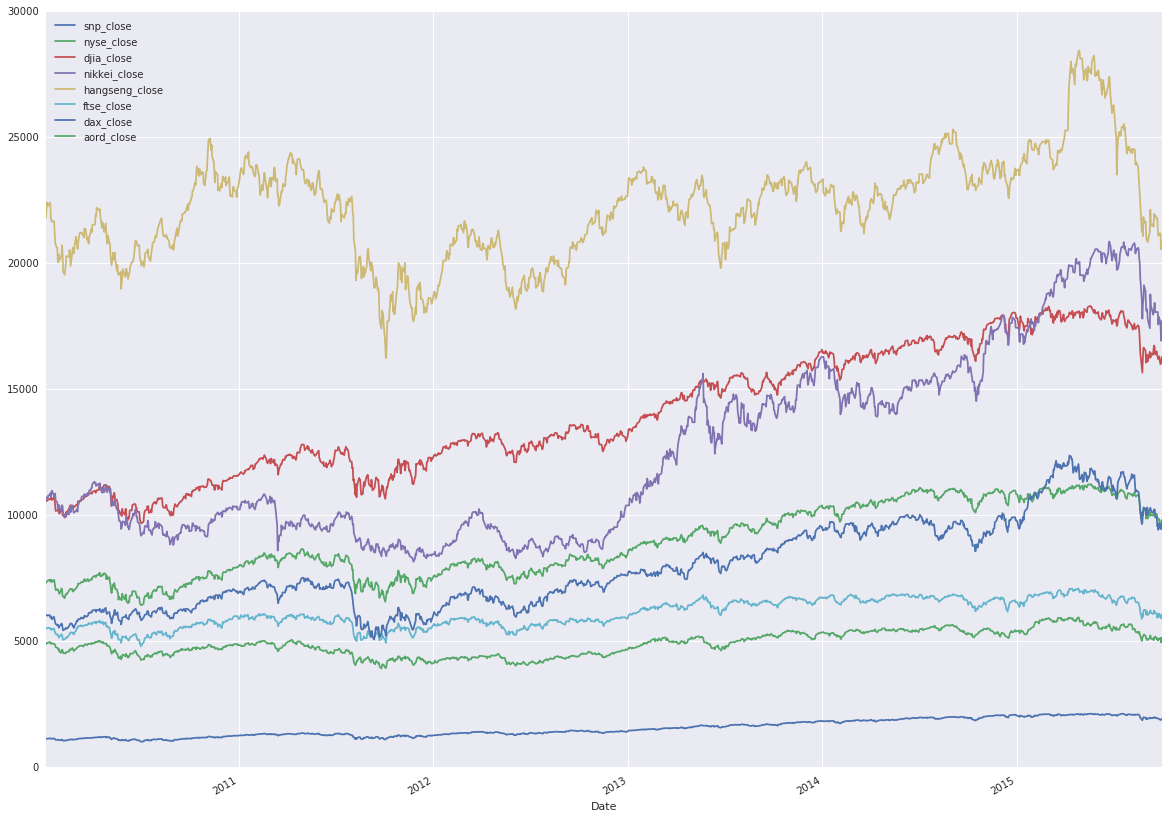

In [28]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = pd.concat([closing_data['snp_close'],
  closing_data['nyse_close'],
  closing_data['djia_close'],
  closing_data['nikkei_close'],
  closing_data['hangseng_close'],
  closing_data['ftse_close'],
  closing_data['dax_close'],
  closing_data['aord_close']], axis=1).plot(figsize=(20, 15))

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1.

In [29]:
closing_data['snp_close_scaled'] = closing_data['snp_close'] / max(closing_data['snp_close'])
closing_data['nyse_close_scaled'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data['djia_close_scaled'] = closing_data['djia_close'] / max(closing_data['djia_close'])
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['hangseng_close_scaled'] = closing_data['hangseng_close'] / max(closing_data['hangseng_close'])
closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])
closing_data['dax_close_scaled'] = closing_data['dax_close'] / max(closing_data['dax_close'])
closing_data['aord_close_scaled'] = closing_data['aord_close'] / max(closing_data['aord_close'])

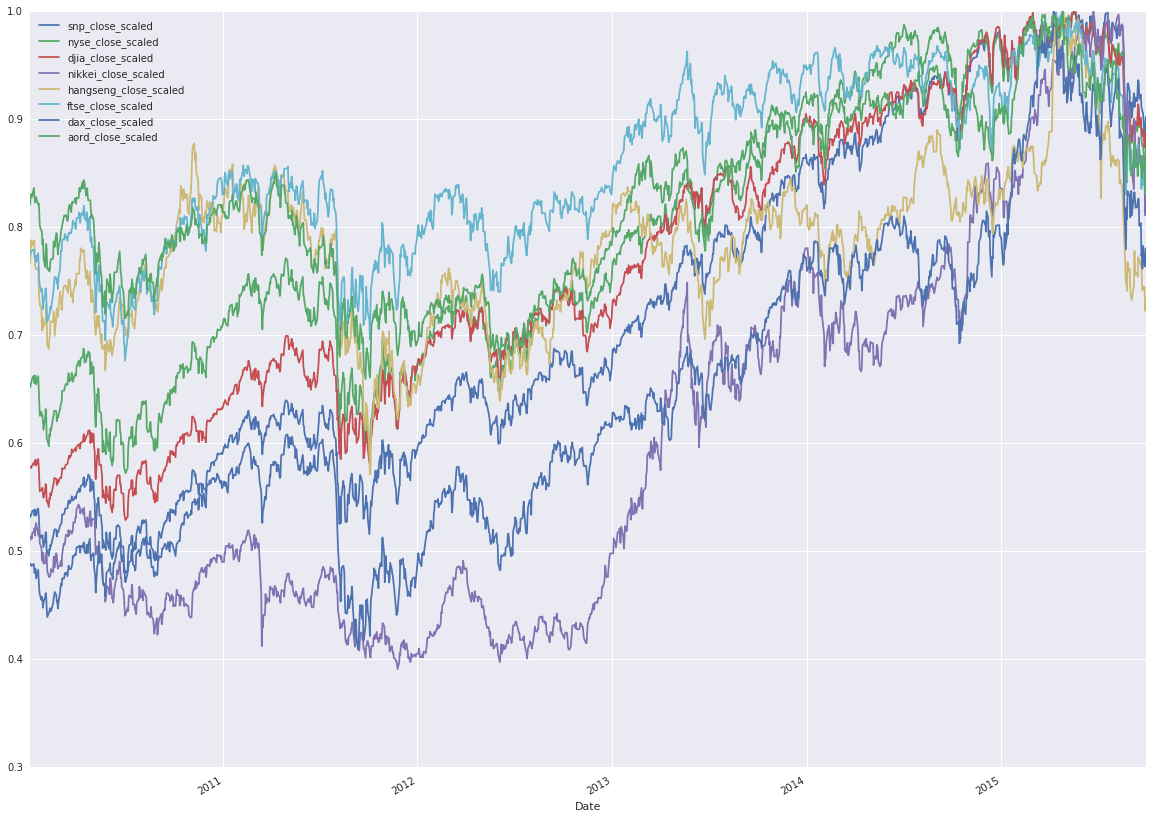

In [30]:
_ = pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1).plot(figsize=(20, 15))

You can see that, over the five-year period, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is an good start, though not the complete story. Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

In [ ]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(closing_data['snp_close'], label='snp_close')
_ = autocorrelation_plot(closing_data['nyse_close'], label='nyse_close')
_ = autocorrelation_plot(closing_data['djia_close'], label='djia_close')
_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['hangseng_close'], label='hangseng_close')
_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')
_ = autocorrelation_plot(closing_data['dax_close'], label='dax_close')
_ = autocorrelation_plot(closing_data['aord_close'], label='aord_close')

_ = plt.legend(loc='upper right')

You should see strong autocorrelations, positive for around 500 lagged days, then going negative. This tells us something we should intuitively know: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

In [ ]:
_ = scatter_matrix(pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1), figsize=(20, 20), diagonal='kde')

You can see significant correlations across the board, further evidence that the premise is workable and one market can be influenced by another. 

As an aside, this process of gradual, incremental experimentation and progress is the best approach and what you probably do normally. With a little patience, we'll get to some deeper understanding.

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

`ln(Vt/Vt-1)`

There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [ ]:
log_return_data = pd.DataFrame()

log_return_data['snp_log_return'] = np.log(closing_data['snp_close']/closing_data['snp_close'].shift())
log_return_data['nyse_log_return'] = np.log(closing_data['nyse_close']/closing_data['nyse_close'].shift())
log_return_data['djia_log_return'] = np.log(closing_data['djia_close']/closing_data['djia_close'].shift())
log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['hangseng_log_return'] = np.log(closing_data['hangseng_close']/closing_data['hangseng_close'].shift())
log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())
log_return_data['dax_log_return'] = np.log(closing_data['dax_close']/closing_data['dax_close'].shift())
log_return_data['aord_log_return'] = np.log(closing_data['aord_close']/closing_data['aord_close'].shift())

log_return_data.describe()

Looking at the log returns, you should see that the mean, min, max are all similar. You could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

In [ ]:
_ = pd.concat([log_return_data['snp_log_return'],
  log_return_data['nyse_log_return'],
  log_return_data['djia_log_return'],
  log_return_data['nikkei_log_return'],
  log_return_data['hangseng_log_return'],
  log_return_data['ftse_log_return'],
  log_return_data['dax_log_return'],
  log_return_data['aord_log_return']], axis=1).plot(figsize=(20, 15))

You can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

In [ ]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(log_return_data['snp_log_return'], label='snp_log_return')
_ = autocorrelation_plot(log_return_data['nyse_log_return'], label='nyse_log_return')
_ = autocorrelation_plot(log_return_data['djia_log_return'], label='djia_log_return')
_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['hangseng_log_return'], label='hangseng_log_return')
_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')
_ = autocorrelation_plot(log_return_data['dax_log_return'], label='dax_log_return')
_ = autocorrelation_plot(log_return_data['aord_log_return'], label='aord_log_return')

_ = plt.legend(loc='upper right')

No autocorrelations are visible in the plot, which is what we're looking for. Individual financial markets are Markov processes, knowledge of history doesn't allow you to predict the future. 

You now have time series for the indices, stationary in the mean, similarly centered and scaled. That's great! Now start to look for signals to try to predict the close of the S&P 500. 

Look at a scatterplot to see how the log return indices correlate with each other.

In [ ]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with the previous scatter plot for log returns is more subtle and more interesting. The US indices are strongly correlated, as expected. The other indices, less so, which is also expected. But there is structure and signal there. Now let's move forward and start to quantify it so we can start to choose features for our model.

First look at how the log returns for the closing value of the S&P 500 correlate with the closing values of other indices available on the same day. This essentially means to assume the indices that close before the S&P 500 (non-US indices) are available and the others (US indices) are not.

In [ ]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift()
tmp['djia_1'] = log_return_data['djia_log_return'].shift()
tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp['dax_0'] = log_return_data['dax_log_return']
tmp['hangseng_0'] = log_return_data['hangseng_log_return']
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['aord_0'] = log_return_data['aord_log_return']
tmp.corr().iloc[:,0]

Here, we are directly working with the premise. We're correlating the close of the S&P 500 with signals available before the close of the S&P 500.  And you can see that the S&P 500 close is correlated with European indices at around 0.65 for the FTSE and DAX, which is a strong correlation, and Asian/Oceanian indices at around 0.15-0.22, which is a significant correlation, but not with US indices. We have available signals from other indices and regions for our model.

Now look at how the log returns for the S&P closing values correlate with index values from the previous day to see if they previous closing is predictive. Following from the premise that financial markets are Markov processes, there should be little or no value in historical values.

In [ ]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(2)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(2)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift()
tmp['dax_0'] = log_return_data['dax_log_return'].shift()
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift()
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift()
tmp['aord_0'] = log_return_data['aord_log_return'].shift()
tmp.corr().iloc[:,0]

You should see little to no correlation in this data, meaning that yesterday's values are no practical help in predicting today's close. Let's go one step further and look at correlations between today and the the day before yesterday.

In [ ]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(3)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(3)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(2)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(2)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(2)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(2)

tmp.corr().iloc[:,0]

Again, there are little to no correlations.

## Summing up the EDA

At this point, you've done a good enough job of exploratory data analysis. You've visualized our data and come to know it better. You've transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. You've seen that indices from Europe strongly correlate with US indices, and that indices from Asia/Oceania significantly correlate with those same indices for a given day. You've also seen that if you look at historical values, they do not correlate with today's values. Summing up:

* European indices from the same day were a strong predictor for the S&P 500 close.
* Asian/Oceanian indices from the same day were a significant predictor for the S&P 500 close.
* Indices from previous days were not good predictors for the S&P close.

What should we think so far?

Cloud Datalab is working great. With just a few lines of code, you were able to munge the data, visualize the changes, and make decisions. You could easily analyze and iterate. This is a common feature of iPython, but the advantage here is that Cloud Datalab is a managed service that you can simply click and use, so you can focus on your analysis.

## Feature selection

At this point, we can see a model:

* We'll predict whether the S&P 500 close today will be higher or lower than yesterday.
* We'll use all our data sources: NYSE, DJIA, Nikkei, Hang Seng, FTSE, DAX, AORD.
* We'll use three sets of data points—T, T-1, and T-2—where we take the data available on day T or T-n, meaning today's non-US data and yesterday's US data.

Predicting whether the log return of the S&P 500 is positive or negative is a classification problem. That is, we want to choose one option from a finite set of options, in this case positive or negative. This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

This uses the findings from of our exploratory data analysis, namely that log returns from other regions on a given day are strongly correlated with the log return of the S&P 500, and there are stronger correlations from those regions that are geographically closer with respect to time zones. However, our models also use data outside of those findings. For example, we use data from the past few days in addition to today.  There are two reasons for using this additional data. First, we're adding additional features to our model for the purpose of this solution to see how things perform. which is not a good reason to add features outside of a tutorial setting. Second, machine learning models are very good at finding weak signals from data.

In machine learning, as in most things, there are subtle tradeoffs happening, but in general good data is better than good algorithms, which are better than good frameworks. You need all three pillars but in that order of importance: data, algorithms, frameworks.

## TensorFlow

[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. TensorFlow is based on Google's machine learning expertise and is the next generation framework used internally at Google for tasks such as translation and image recognition. It's a wonderful framework for machine learning because it's expressive, efficient, and easy to use.

### Feature engineering for TensorFlow

From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time.  Otherwise,  your model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because you can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Decide on a training-versus-testing split, and divide your data into training and test datasets.

In this case, you'll create the features together with two additional columns:

*  snp_log_return_positive, which is 1 if the log return of the S&P 500 close is positive, and 0 otherwise. 
* snp_log_return_negative, which is 1 if the log return of the S&P 500 close is negative, and 1 otherwise. 

Now, logically you could encode this information in one column, named snp_log_return, which is 1 if positive and 0 if negative, but that's not the way TensorFlow works for classification models. TensorFlow uses the general definition of classification, that there can be many different potential values to choose from, and a form or encoding for these options called one-hot encoding. One-hot encoding means that each choice is an entry in an array, and the actual value has an entry of 1 with all other values being 0. This encoding (i.e. a single 1 in an array of 0s) is for the input of the model, where you categorically know which value is correct. A variation of this is used for the output, where each entry in the array contains the probability of the answer being that choice. You can then choose the most likely value by choosing the highest probability, together with having a measure of the confidence you can place in that answer relative to other answers.

We'll use 80% of our data for training and 20% for testing.

In [ ]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.ix[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.ix[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

for i in range(7, len(log_return_data)):
  snp_log_return_positive = log_return_data['snp_log_return_positive'].ix[i]
  snp_log_return_negative = log_return_data['snp_log_return_negative'].ix[i]
  snp_log_return_1 = log_return_data['snp_log_return'].ix[i-1]
  snp_log_return_2 = log_return_data['snp_log_return'].ix[i-2]
  snp_log_return_3 = log_return_data['snp_log_return'].ix[i-3]
  nyse_log_return_1 = log_return_data['nyse_log_return'].ix[i-1]
  nyse_log_return_2 = log_return_data['nyse_log_return'].ix[i-2]
  nyse_log_return_3 = log_return_data['nyse_log_return'].ix[i-3]
  djia_log_return_1 = log_return_data['djia_log_return'].ix[i-1]
  djia_log_return_2 = log_return_data['djia_log_return'].ix[i-2]
  djia_log_return_3 = log_return_data['djia_log_return'].ix[i-3]
  nikkei_log_return_0 = log_return_data['nikkei_log_return'].ix[i]
  nikkei_log_return_1 = log_return_data['nikkei_log_return'].ix[i-1]
  nikkei_log_return_2 = log_return_data['nikkei_log_return'].ix[i-2]
  hangseng_log_return_0 = log_return_data['hangseng_log_return'].ix[i]
  hangseng_log_return_1 = log_return_data['hangseng_log_return'].ix[i-1]
  hangseng_log_return_2 = log_return_data['hangseng_log_return'].ix[i-2]
  ftse_log_return_0 = log_return_data['ftse_log_return'].ix[i]
  ftse_log_return_1 = log_return_data['ftse_log_return'].ix[i-1]
  ftse_log_return_2 = log_return_data['ftse_log_return'].ix[i-2]
  dax_log_return_0 = log_return_data['dax_log_return'].ix[i]
  dax_log_return_1 = log_return_data['dax_log_return'].ix[i-1]
  dax_log_return_2 = log_return_data['dax_log_return'].ix[i-2]
  aord_log_return_0 = log_return_data['aord_log_return'].ix[i]
  aord_log_return_1 = log_return_data['aord_log_return'].ix[i-1]
  aord_log_return_2 = log_return_data['aord_log_return'].ix[i-2]
  training_test_data = training_test_data.append(
    {'snp_log_return_positive':snp_log_return_positive,
    'snp_log_return_negative':snp_log_return_negative,
    'snp_log_return_1':snp_log_return_1,
    'snp_log_return_2':snp_log_return_2,
    'snp_log_return_3':snp_log_return_3,
    'nyse_log_return_1':nyse_log_return_1,
    'nyse_log_return_2':nyse_log_return_2,
    'nyse_log_return_3':nyse_log_return_3,
    'djia_log_return_1':djia_log_return_1,
    'djia_log_return_2':djia_log_return_2,
    'djia_log_return_3':djia_log_return_3,
    'nikkei_log_return_0':nikkei_log_return_0,
    'nikkei_log_return_1':nikkei_log_return_1,
    'nikkei_log_return_2':nikkei_log_return_2,
    'hangseng_log_return_0':hangseng_log_return_0,
    'hangseng_log_return_1':hangseng_log_return_1,
    'hangseng_log_return_2':hangseng_log_return_2,
    'ftse_log_return_0':ftse_log_return_0,
    'ftse_log_return_1':ftse_log_return_1,
    'ftse_log_return_2':ftse_log_return_2,
    'dax_log_return_0':dax_log_return_0,
    'dax_log_return_1':dax_log_return_1,
    'dax_log_return_2':dax_log_return_2,
    'aord_log_return_0':aord_log_return_0,
    'aord_log_return_1':aord_log_return_1,
    'aord_log_return_2':aord_log_return_2},
    ignore_index=True)
  
training_test_data.describe()

Now, create the training and test data.

In [ ]:
predictors_tf = training_test_data[training_test_data.columns[2:]]

classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

In [ ]:
test_predictors_tf.describe()

Define some metrics here to evaluate the models.

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) -  The ability of the classifier not to label as positive a sample that is negative.
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) - The ability of the classifier to find all the positive samples.
* [F1 Score](https://en.wikipedia.org/wiki/F1_score) - A weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
* Accuracy - The percentage correctly predicted in the test data.

In [ ]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpr = float(tp)/(float(tp) + float(fn))
  fpr = float(fp)/(float(tp) + float(fn))

  accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))

  recall = tpr
  precision = float(tp)/(float(tp) + float(fp))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print 'Precision = ', precision
  print 'Recall = ', recall
  print 'F1 Score = ', f1_score
  print 'Accuracy = ', accuracy

### Binary classification with TensorFlow

Now, get some tensors flowing. The model is binary classification expressed in TensorFlow.

In [ ]:
sess = tf.Session()

# Define variables for the number of predictors and number of classes to remove magic numbers from our code.
num_predictors = len(training_predictors_tf.columns) # 24 in the default case
num_classes = len(training_classes_tf.columns) # 2 in the default case

# Define placeholders for the data we feed into the process - feature data and actual classes.
feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, num_classes])

# Define a matrix of weights and initialize it with some small random values.
weights = tf.Variable(tf.truncated_normal([num_predictors, num_classes], stddev=0.0001))
biases = tf.Variable(tf.ones([num_classes]))

# Define our model...
# Here we take a softmax regression of the product of our feature data and weights.
model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

# Define a cost function (we're using the cross entropy).
cost = -tf.reduce_sum(actual_classes*tf.log(model))

# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess.run(init)

We'll train our model in the following snippet. The approach of TensorFlow to executing graph operations allows fine-grained control over the process. Any operation you provide to the session as part of the run operation will be executed and the results returned. You can provide a list of multiple operations.

You'll train the model over 30,000 iterations using the full dataset each time. Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

In [ ]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
  sess.run(
    training_step, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print i, sess.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )

An accuracy of 65% on the training data is fine, certainly better than random.

In [ ]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess, feed_dict)

The metrics for this most simple of TensorFlow models are unimpressive, an F1 Score of 0.36 is not going to blow any light bulbs in the room. That's partly because of its simplicity and partly because It hasn't been tuned; selection of hyperparameters is very important in machine learning modelling.

### Feed-forward neural network with two hidden layers

You'll now build a proper feed-forward neural net with two hidden layers.

In [ ]:
sess1 = tf.Session()

num_predictors = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)

feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, 2])

weights1 = tf.Variable(tf.truncated_normal([24, 50], stddev=0.0001))
biases1 = tf.Variable(tf.ones([50]))

weights2 = tf.Variable(tf.truncated_normal([50, 25], stddev=0.0001))
biases2 = tf.Variable(tf.ones([25]))
                     
weights3 = tf.Variable(tf.truncated_normal([25, 2], stddev=0.0001))
biases3 = tf.Variable(tf.ones([2]))

hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)
model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3)

cost = -tf.reduce_sum(actual_classes*tf.log(model))

train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess1.run(init)

Again, you'll train the model over 30,000 iterations using the full dataset each time. Every thousandth iteration, you'll assess the accuracy of the model on the training data to assess progress.

In [ ]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
  sess1.run(
    train_op1, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print i, sess1.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )

A significant improvement in accuracy with the training data shows that the hidden layers are adding additional capacity for learning to the model.

Looking at precision, recall, and accuracy, you can see a measurable improvement in performance, but certainly not a [step function](https://wikipedia.org/wiki/Step_function). This indicates that we're likely reaching the limits of this relatively simple feature set.

In [ ]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)

## Conclusion

You've covered a lot of ground. You moved from sourcing five years of financial time-series data, to munging that data into a more suitable form. You explored and visualized that data with exploratory data analysis and then decided on a machine learning model and the features for that model. You engineered those features, built a binary classifier in TensorFlow, and analyzed its performance. You built a feed forward neural net with two hidden layers in TensorFlow and analyzed its performance.

How did the technology fare? It should take most people 1.5 to 3 hours to extract the juice from this solution, and none of that time is spent waiting for infrastructure or software; it's spent reading and thinking. In many organizations, it can take anywhere from days to months to do this sort of data analysis, depending on whether you need to procure any hardware. And you didn't need to do anything with infrastructure or additional software. Rather, you used a web-based console to direct GCP to set up systems on your behalf, which it did—fully managed, maintained, and supported—freeing you up to spend your time analyzing. 

It was also cost effective. If you took your time with this solution and spent three hours to go through it, the cost would be a few pennies. 

Cloud Datalab worked admirably, too. iPython/Jupyter has always been a great platform for interactive, iterative work and a fully-managed version of that platform on GCP, with connectors to other GCP technologies such as BigQuery and Google Cloud Storage, is a force multiplier for your analysis needs.  If you haven't used iPython before, this solution might have been eye opening, for you. If you're already familiar with iPython, then you'll love the connectors to other GCP technologies.

Of course, R and Matlab are popular tools in machine learning, and we've made no mention either in this solution. Neither R nor Matlab are available as managed services on GCP. Both can be hosted in GCP and accessed through a cloud-friendly, web frontend.

TensorFlow is a special piece of technology. It is expressive, performs well, and comes with the weight of Google's machine learning history and expertise to back it up and support it. We've only scratched the surface, but you can already see that within a handful of lines of code we've been able to write two models. Neither of them is cutting edge, by design, but neither of them is trivial either. With some additional tuning they would suit a whole spectrum of machine learning tasks. 

Finally, how did we do with the data analysis? We did well: over 70% accuracy in predicting the close of the S&P 500 is the highest we've seen achieved on this dataset, so with few steps and a few lines of code we've produced a full-on machine learning model. The reason for the relatively modest accuracy achieved is the dataset itself; there isn't enough signal there to do significantly better. But 7 times out of 10, we were able to correctly determine if the S&P 500 index would close up or down on the day, and that's objectively good.

## Cleanup

**When you're finished, shut down the managed VM you used for Cloud Datalab to avoid incurring costs.**

In [ ]:
print '''
Copyright 2015, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''